# Bitcoin Sentiment Analysis via Tweets

## Readme

### *Data dictionary*

##### - Tweets on bitcoin dataset
![alt_text](https://drive.google.com/uc?id=1Y0R9XTUqI0Xxy7tu-o3KNLXNPCNtT1-7)


##### - Bitcoin values dataset
![alt_text](https://drive.google.com/uc?id=10veY8UqljXcpuvD-Jhmsh6dGkbhzTklX)

### *Goal*

1. Obtain sentiment of tweets (negative,positive, neutral)
2. Show daily trend of sentiment tweets through a linechart
3. Check if:
  
    a. Negative tweets tend to obtain more like compared to positive tweets

    b. Negative tweets receive more answers compared to positive tweets

4. Test association between bitcoin value variation and sentiment tweet variation

### *Index*

Library

0. Update dataset
1. First requests
2. Second request
3. Third request

Conclusion

## Library

In [1]:
!pip install -U textblob
!pip install langdetect
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 18.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=a4644286c6d1e2e0beaea90464ecd8a2838ec286a84613f1cd0dd74334177da6
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 16.8 MB/s eta 0:00:00


In [2]:
## Library

### Pyspark
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import col,udf,to_date,avg,lag,log
from pyspark.sql.types import StringType

### Sentiment analysis and NLP
from textblob import TextBlob
from langdetect import detect
import emoji
import re

### Basic lib
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt

### Sklearn
from sklearn.preprocessing import MinMaxScaler

## 0. Upload dataset

In [3]:
## Upload dataset
# Download the file into /tmp/
!wget -O /tmp/bitcoin_tweets.csv https://proai-datasets.s3.eu-west-3.amazonaws.com/bitcoin_tweets.csv

import pandas as pd
dataset = pd.read_csv('/tmp/bitcoin_tweets.csv', delimiter=",")

spark = SparkSession.builder.getOrCreate()
spark_df = spark.createDataFrame(dataset)

--2025-12-19 09:51:57--  https://proai-datasets.s3.eu-west-3.amazonaws.com/bitcoin_tweets.csv
Resolving proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)... 52.95.154.44, 3.5.205.175
Connecting to proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)|52.95.154.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24708828 (24M) [text/csv]
Saving to: ‘/tmp/bitcoin_tweets.csv’

/tmp/bitcoin_tweets 100%[===================>]  23.56M  10.5MB/s    in 2.3s    

2025-12-19 09:52:00 (10.5 MB/s) - ‘/tmp/bitcoin_tweets.csv’ saved [24708828/24708828]



In [4]:
## Check type of columns
spark_df.printSchema() # When I'll create the line chart, I'll convert the ‘timestamp column’ from string to date.

root
 |-- id: double (nullable = true)
 |-- user: string (nullable = true)
 |-- fullname: string (nullable = true)
 |-- url: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- replies: double (nullable = true)
 |-- likes: double (nullable = true)
 |-- retweets: double (nullable = true)
 |-- text: string (nullable = true)



## 1. First requests

1. Classify daily tweets about Bitcoin as positive, negative, or neutral.

2. Plot a time series showing daily counts of each sentiment to visualize public opinion trends.


#### 1.1 Classify daily tweets

##### 1.1.1 Data preprocessing

In [5]:
##  Check if there are any NULL values in "text" column
display(spark_df.filter(col("text").isNull()))

## Detect languages

## Detect language and return "unknown" if the language is not supported
def detect_lang(text):
    try:
        return detect(text)
    except:
        return "unknown"

## Create UDF (User Defined Function) to use new python function with spark dataframe
detect_lang_udf = udf(detect_lang, StringType())

## Create a new column with the language detected
df_lang=spark_df.withColumn("lang", detect_lang_udf(col("text")))

## See dataset with new column "lang"
display(df_lang)

DataFrame[id: double, user: string, fullname: string, url: string, timestamp: string, replies: double, likes: double, retweets: double, text: string]

DataFrame[id: double, user: string, fullname: string, url: string, timestamp: string, replies: double, likes: double, retweets: double, text: string, lang: string]

In [6]:
## How many tweets are in each language?
df_lang.groupBy("lang").count().sort("count",ascending=False).show()

## I'll use only english tweets (75.135) because I am going to use TextBlob to analyze sentiment and it only supports English language
df_eng=df_lang.filter(col("lang")=="en")


+-------+-----+
|   lang|count|
+-------+-----+
|     en|75135|
|     ja|10361|
|     es| 2258|
|     tr| 2115|
|     de| 1648|
|     pt|  937|
|     fr|  889|
|unknown|  819|
|     nl|  764|
|     it|  538|
|     id|  400|
|     so|  397|
|     vi|  392|
|     ro|  375|
|     ru|  351|
|     ca|  254|
|     tl|  226|
|     fi|  181|
|     hr|  180|
|     pl|  173|
+-------+-----+
only showing top 20 rows


In [7]:
## Delete retweets because I only want original tweets
df_ret=df_eng.filter(col("text").startswith("RT")==False)

In [8]:
## Check if there are duplicate user and id tweet
df_ret.groupBy(["user","id"]).count().sort("count", ascending=False).show()

## Delete duplicate
df_fin=df_ret.dropDuplicates(["id"])


+--------------+--------------------+-----+
|          user|                  id|count|
+--------------+--------------------+-----+
|   DeribitRekt|1.132980772334374...|    3|
| webnowcompany|1.126891705821736...|    2|
|   DeribitRekt|1.132980268455878...|    2|
|   DeribitRekt|1.132980772321804...|    2|
|   DeribitRekt|1.132980772351221...|    2|
| webnowcompany|1.126891705796583...|    2|
|   DeribitRekt|1.132980268447469...|    2|
| webnowcompany|1.126891705817603...|    2|
| webnowcompany|1.126891705800822...|    2|
|    CoinCapsAi|1.132977256316526...|    1|
|  vegardwikeby|1.132861174171750...|    1|
|  ColinTCrypto|1.132649392920514...|    1|
|  mineshaft_io|1.132979772798263...|    1|
|  CryptoHourly|1.132979774333362...|    1|
|vinmaxinfotech|1.132980594265219...|    1|
| SidneyVollmer|1.132981000445792...|    1|
| RezoanulVibes|1.132982318946066...|    1|
| Tanni20273461|1.126824153137332...|    1|
|      somsirsa|1.126820317710692...|    1|
|    sherangot7|1.12682148241020

In [9]:
## Remove emoji and url from "text" column

# NOTE: I used this function from : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b

def remove_emoji_url(string):
    # Remove emoji
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags
        u"\U00002500-\U00002BEF"  # chinese chars
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"
        u"\u3030"
        u"\u205A"
        "]+", flags=re.UNICODE)

    # Remove url
    url_pattern = re.compile(r"https?://\S+|www\.\S+") # remove url such as http or https and www.

    # Remove special characters
    spec_char_pat=re.compile(r"[^\w\s.,?!]")

    # Apply all the functions
    string = emoji_pattern.sub(r"", string)   # Removing emoji
    string = url_pattern.sub(r"", string)     # Removing url
    string = spec_char_pat.sub(r"", string)   # Removimg special characters
    return string


In [10]:
## From python function to spark function with UDF (User Defined Function)
remove_emoji_url_udf=udf(remove_emoji_url,StringType())

# Remove emoji, url and special characters
df_clean=df_fin.withColumn("text", remove_emoji_url_udf(col("text")))

##### 1.1.2 Sentiment Analysis

In [11]:
#Sentiment analysis

# Create function to define sentiment polarity of tweet
def get_sentiment(df_clean):

	analysis = TextBlob(df_clean)

    ## 1:positive
	if analysis.sentiment.polarity > 0:
		return 1

    ## 0:negative
	elif analysis.sentiment.polarity < 0:
		return 0

    ## 2:neutral
	else: return 2

# Create and convert from Python function to PySpark function
sentiment_udf = udf(get_sentiment, StringType())

## Create the column "sentiment_label" in the new dataset df_fin
df_fin =df_clean.withColumn("sentiment_label", sentiment_udf(col("text")))

In [12]:
### How many tweets are positive (1), negative (0) and neutral (2)?
df_fin.groupBy("sentiment_label").count().show()


+---------------+-----+
|sentiment_label|count|
+---------------+-----+
|              0| 9007|
|              1|32006|
|              2|33788|
+---------------+-----+



#### 1.2 Graph showing sentiment of tweets per daily tweet

In [13]:
## Create a graph with tweet sentiment grouped by daily tweet

# Get the date
df_fin=df_fin.withColumn("date",to_date(col("timestamp")))

## Count labels for each day
df_count_lab = df_fin.groupBy("date", "sentiment_label").count().orderBy("date")

## Convert to pandas dataframe
df_count_pd=df_count_lab.toPandas()

## Create a pivot table with columns for each label in order to obtain the count of tweets with sentiment labels for each date
df_count_pd['date'] = pd.to_datetime(df_count_pd['date'])

## Pivot table
pivot_lab = df_count_pd.pivot(index='date', columns='sentiment_label', values='count').fillna(0)

## Reset index (date) because "date" column results as object type after pivot operation
pivot_lab = pivot_lab.reset_index()

## Convert column "date" to date type
pivot_lab['date'] = pivot_lab['date'].dt.date

In [14]:
## Show pivot_lab
display(pivot_lab)

sentiment_label,date,0,1,2
0,2009-01-11,0.0,0.0,1.0
1,2012-08-02,0.0,1.0,0.0
2,2013-08-16,0.0,1.0,0.0
3,2013-12-09,0.0,0.0,1.0
4,2013-12-19,0.0,0.0,1.0
...,...,...,...,...
520,2019-05-23,1.0,3.0,2.0
521,2019-05-24,0.0,5.0,2.0
522,2019-05-25,1.0,6.0,7.0
523,2019-05-26,8.0,41.0,20.0


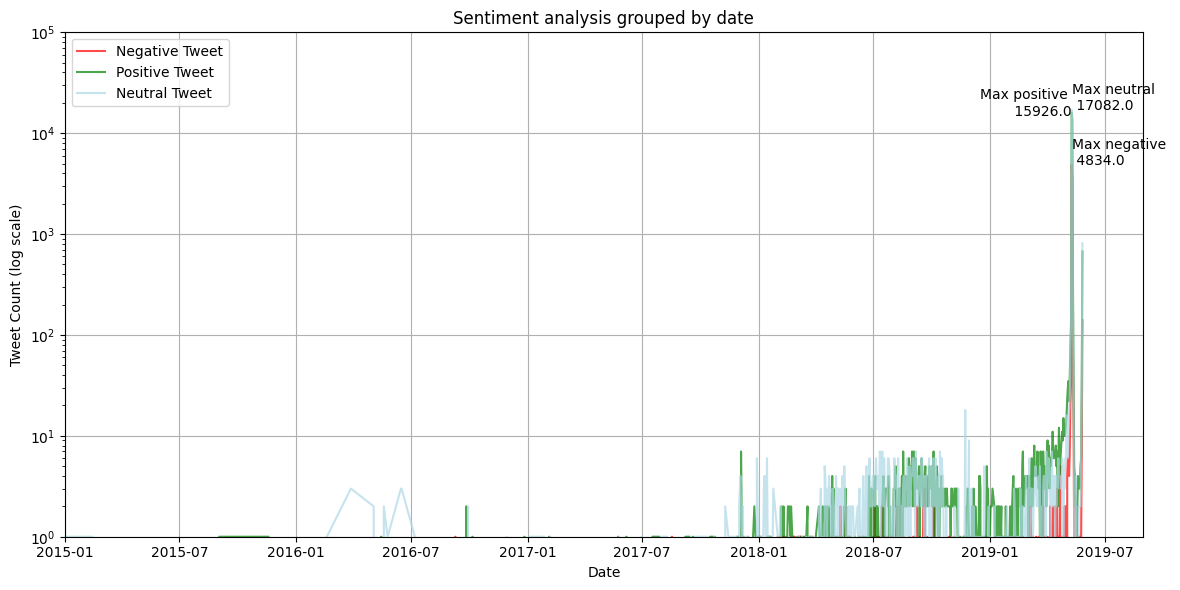

In [ ]:
## LINE CHART

## Get max number of tweet in order to write on line chart
max0_count=pivot_lab["0"].max()
max1_count=pivot_lab["1"].max()
max2_count=pivot_lab["2"].max()
display([max0_count,max1_count,max2_count])
# Obtain date of maximum number of tweet for each type
max0_date=pivot_lab["date"][pivot_lab["0"] == pivot_lab["0"].max()]
max1_date=pivot_lab["date"][pivot_lab["1"] == pivot_lab["1"].max()]
max2_date=pivot_lab["date"][pivot_lab["2"] == pivot_lab["2"].max()]
display([max0_date,max1_date,max2_date])

## Create linechart to show trend of sentiment
pivot_lab.plot.line(
    x="date",
    y=["0", "1", "2"],
    figsize=(12, 6),
    title="Sentiment analysis grouped by date",
    logy=True, # log scale to reduce the scale of the graph
    alpha=0.7,
    color=['red','green','lightblue']
)

## Name axis and legend
plt.legend(["Negative Tweet","Positive Tweet", "Neutral Tweet"],loc="upper left")
plt.xlabel("Date")
plt.ylabel("Tweet Count (log scale)")

## Take note of the maximum number of tweets for each type of sentiment
plt.annotate(f"Max negative \n {max0_count}", xy=(max0_date,max0_count))
plt.annotate(f"Max positive \n {max1_count}", xy=(max1_date,max1_count),xytext=(max1_date,max1_count-1000),ha="right")
plt.annotate(f"Max neutral \n {max2_count}", xy=(max2_date,max2_count))

## Axis limits
plt.ylim(1,100000)
plt.xlim(pd.to_datetime("2015-01-01"), pd.to_datetime("2019-08-31"))

## General setting of chart
plt.grid(True)
plt.tight_layout()
plt.show()

### I chose to show only the period from 2015 to 2019 because there are few tweets from 2009 to 2014

#### NOTE: UserWarning derives from my error to define limit of y as 0,100000.

## 2. Second request


-  Are there any differences in the number of like and replies between positive and negative tweet?


In [ ]:
## Create the two subset
pos=df_fin.filter(df_fin.sentiment_label==1)
neg=df_fin.filter(df_fin.sentiment_label==0)

In [ ]:
## Use toPandas in order to get descriptive statistics and create graphs
pos_pd=pos.toPandas()
neg_pd=neg.toPandas()

In [ ]:
# Descriptive statistics
print(pos_pd.describe())
print(neg_pd.describe())

# Custom quantiles

print(pos_pd[["likes","replies","retweets"]].quantile([0.25,0.5,0.75,0.90,0.95,0.99]))
print(neg_pd[["likes","replies","retweets"]].quantile([0.25,0.5,0.75,0.90,0.95,0.99]))


                 id       replies         likes      retweets
count  3.201400e+04  32014.000000  32014.000000  32014.000000
mean   1.124739e+18      1.368558      9.988724      4.146561
std    1.805558e+16     21.207591     92.847257     65.574403
min    2.311112e+17      0.000000      0.000000      0.000000
25%    1.126881e+18      0.000000      0.000000      0.000000
50%    1.126981e+18      0.000000      0.000000      0.000000
75%    1.127115e+18      0.000000      0.000000      0.000000
max    1.132985e+18   2104.000000   5549.000000   7816.000000
                 id      replies        likes     retweets
count  9.012000e+03  9012.000000  9012.000000  9012.000000
mean   1.125601e+18     1.239348    10.719818     3.215158
std    1.406024e+16    11.299873    97.957768    39.098718
min    7.274586e+17     0.000000     0.000000     0.000000
25%    1.126890e+18     0.000000     0.000000     0.000000
50%    1.126976e+18     0.000000     0.000000     0.000000
75%    1.127100e+18     0.000

##### **Note on distribution of like and replies:**
##### **- LIKE insights**
##### 1. Two samples have different numbers of observation
##### 2. Two means and standard deviation (std high variance) are different but median is 0 in both samples. In fact, quantiles show how about 70% of tweet have zero like.
##### Only 10% of tweet received number of like between 1 and 4, 5% received 27 likes and only 1% received more than 100 likes.
##### 3. Descriptive results show there is no difference between positive and negative tweet in terms of number of likes.
##### 4. Exploring with graph
----
##### **- REPLIES insights** #####
##### 1. Two samples have different numbers of observation
##### 2. Two means and standard deviation are different, specifically it seems there is more variance in positive tweet than negative but median is 0 in both samples. In fact, quantiles show how 90% of tweet have zero replies, 5% of tweet received number of replies greater than 0 and only 1% received more than 10 replies.
##### 3. The descriptive results show that there is no difference between positive and negative tweets in terms of the number of replies.
#####    The slight differences in the average could be due to the presence of outliers.
##### 4. Exploring with graph

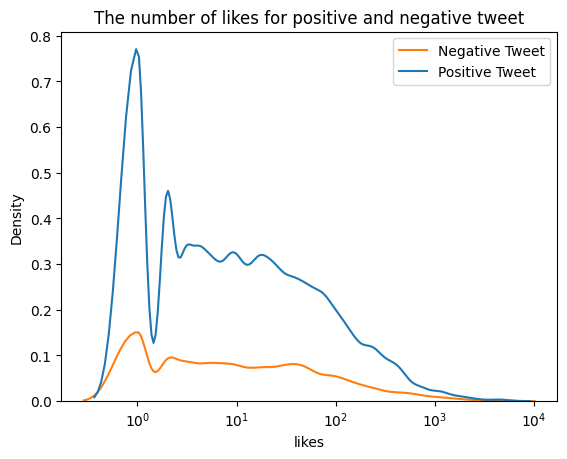

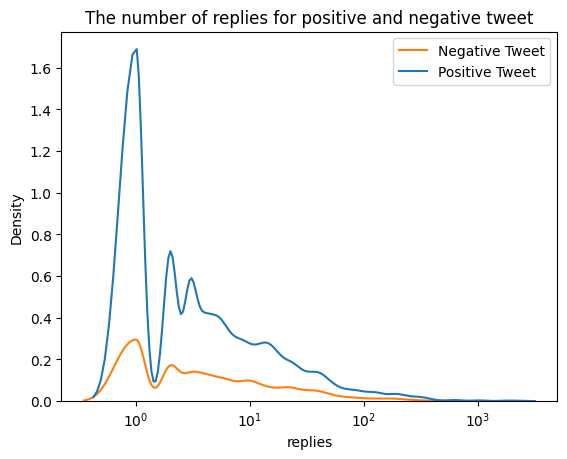

In [ ]:
## Show the two distributions

# Create a dataset that combines the two sample in order to show
# if there are difference between positive and negative tweets per number of like and replies
df_combined = pd.concat([pos_pd, neg_pd], ignore_index=True)

# Create a dataset without zero likes in order to use KDE and log scale
## Engagement data (such as likes, replies, etc.) usually has many small values, which is why it is useful to
## apply a logarithmic scale to better visualise all areas of a distribution
df_nozero_like=df_combined[df_combined["likes"]>0]
df_nozero_repl=df_combined[df_combined["replies"]>0]

# KDE plots are used for exploratory analysis of distribution shape
## Create "like" KDE graph
sbn.kdeplot(data=df_nozero_like, x="likes", hue="sentiment_label", log_scale=True, bw_adjust=0.5)
plt.legend(["Negative Tweet","Positive Tweet"])
plt.xscale("symlog",linthresh=1) ## symlog manage the scale of the graph
plt.title("The number of likes for positive and negative tweet")
plt.show()

## Create "replies" KDE graph
sbn.kdeplot(data=df_nozero_repl,x="replies",hue="sentiment_label",log_scale=True,bw_adjust=0.5)
plt.legend(["Negative Tweet","Positive Tweet"])
plt.xscale("symlog",linthresh=1) ## symlog manage the scale of the graph
plt.title("The number of replies for positive and negative tweet")
plt.show()

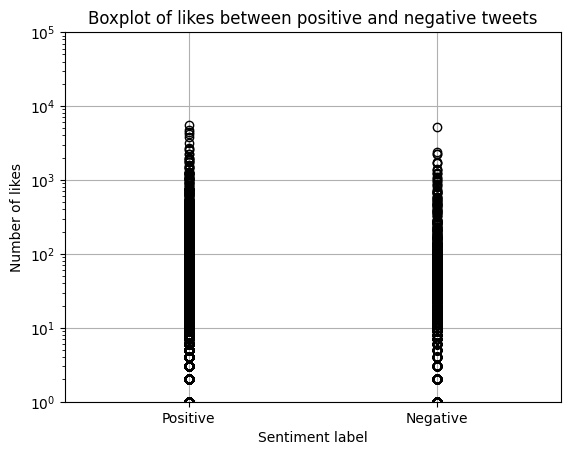

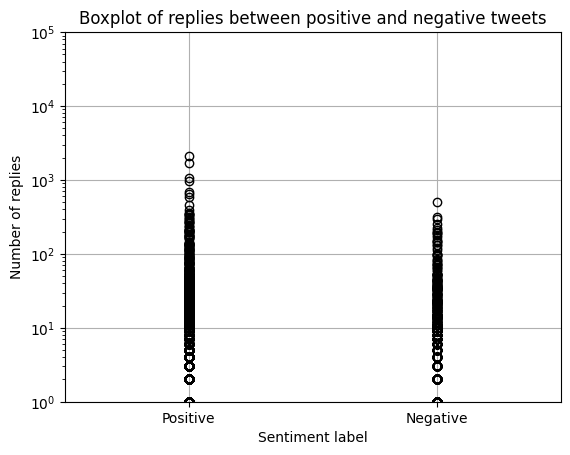

In [ ]:
# Box plots are used to compare dispersion and highlight outliers.

## Boxplot like
plt.boxplot([pos_pd["likes"],neg_pd["likes"]],tick_labels=["Positive","Negative"])
plt.title("Boxplot of likes between positive and negative tweets")
plt.xlabel("Sentiment label")
plt.ylabel("Number of likes")
plt.yscale("log")
plt.ylim(1,100000)
plt.grid(True)
plt.show()

## Boxplot replies
plt.boxplot([pos_pd["replies"],neg_pd["replies"]],tick_labels=["Positive","Negative"])
plt.title("Boxplot of replies between positive and negative tweets")
plt.xlabel("Sentiment label")
plt.ylabel("Number of replies")
plt.yscale("log")
plt.ylim(1,100000)
plt.grid(True)
plt.show()


##### **Note on difference in number between positive and negative tweets**

 Considering the median, quantiles, and graphs, although the average number of likes and replies is slightly different between the positive and negative data sets,the difference is caused by extreme values (especially zero values).
 In fact, both data sets contain extreme values that have increased the average.
 The median is 0 in both distributions, so there are no significant differences between the two data sets.
I chose not to use any tests because:
   1) descriptive statistics and graphs are sufficient to show the difference between the two data sets.
  2) the two data sets show outliers and some users posted both negative and positive posts (paired test, but some users are not completely paired).

## 3. Third request

- Verify whether the fluctuation in the value of Bitcoin affects the change in sentiment in tweets about Bitcoin.

In [ ]:
## Upload bitcoin dataset
## This dataset shows the value of bitcoin by date.
## For each date, the opening, closing, maximum and minimum values and volume are shown.

### Upload dataset using pandas dataframe
df_bit=pd.read_csv(r"https://raw.githubusercontent.com/Profession-AI/progetti-big-data/refs/heads/main/Analisi%20del%20consenso%20sul%20Bitcoin/BTC-USD.csv")

### Convert pandas dataframe in pyspark dataframe
df_bit_sp=spark.createDataFrame(df_bit)
df_bit_sp.createOrReplaceTempView("df_bit_sp")

In [ ]:
## Create date column without time
df_bit_sp=df_bit_sp.withColumn("only_date",to_date(col("Date")))

# Drop "Date" column
df_bit_sp=df_bit_sp.drop("Date")


In [ ]:
# Filter by date both dataset in order to get the same period of time

## Filter the Bitcoin dataset by date in order to compare these values with the date of the sentiment dataset.
df_bit_fin=df_bit_sp.filter((df_bit_sp["only_date"]>="2014-09-17") & (df_bit_sp["only_date"]<="2019-05-27")).sort("only_date",ascending=True)

## Filter with the same date limit for the sentiment dataset
df_fin_filt=df_fin.filter((df_fin["date"]>="2014-09-17") & (df_fin["date"]<="2019-05-27")).sort("date",ascending=True)



In [ ]:
# Create a difference column between OPEN and CLOSE to obtain the change in the price of Bitcoin

## Calculate bitcoin price variation
df_bit_fin=df_bit_fin.withColumn("var_price",log(col("Close"))-log(col("Open")))

# Calculate sentiment variation so as to compare it with Bitcoin price variation

## 1. Daily sentiment average
df_sent1=df_fin_filt.groupBy("date").agg(avg("sentiment_label").alias("sent_avg"))

## 2. Get column with all the previous sentiment
window=Window.orderBy("date")
df_sent2=df_sent1.withColumn("prec_value",lag("sent_avg").over(window))

## 3. Calculate variation between daily sentiment average and the previous sentiment
df_sent_fin=df_sent2.withColumn("var_sent",col("sent_avg")-col("prec_value"))


In [ ]:
# Joim two data sets so that they can be represented in a chart
join_df=df_sent_fin.join(df_bit_fin,df_sent_fin["date"]==df_bit_fin["only_date"],"inner")

In [ ]:
## After window function there is a null value (the first of the column)
## I decided to remove the null value because in this context, having a previous missing value does not make sense
join_df=join_df.filter(col("only_date")!="2014-10-03")


In [ ]:
### Convert pypspark dataframe in pandas dataframe
pddf=join_df.toPandas()

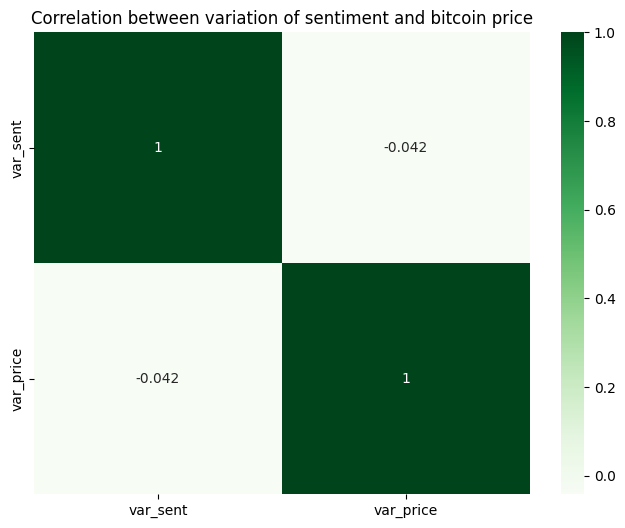

In [ ]:
# Calculate the correlation between sentiment variation and bitcoin price fluctuation
## Is there an association between sentiment and bitcoin price variations?

### Create correlation matrix (Heatmap)
plt.figure(figsize=(8,6))
sbn.heatmap(pddf[["var_sent",'var_price']].corr(method="kendall"),annot=True,cmap="Greens") #I used Kendall's tau because linearity assumption is not checked
plt.title("Correlation between variation of sentiment and bitcoin price")
plt.show()



##### **Note on correlatin matrix output**

###### The correlation result (t: -0.042) shows that there is no correlation between the two variables.

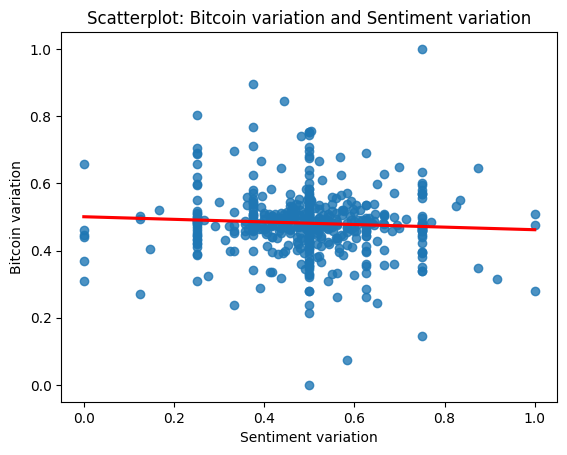

In [ ]:
## Normalise two columns (for RegPlot) so that they have the same variable scale and display the correct result
scaler = MinMaxScaler()
pddf[["var_sent_norm", "var_price_norm"]] = scaler.fit_transform(pddf[["var_sent", "var_price"]])

## Regplot (scatterplot with line)
sbn.regplot(x=pddf["var_sent_norm"],y=pddf["var_price_norm"],ci=None, line_kws={"color": "red"})
plt.xlabel("Sentiment variation")
plt.ylabel("Bitcoin variation")
plt.title("Scatterplot: Bitcoin variation and Sentiment variation")
plt.show()



##### **Note on RegPlot output**

##### The relationship is slightly negative. The result confirms the output of the correlation matrix. Therefore, based on these analyses, there are no associations between sentiment and changes in the price of Bitcoin.

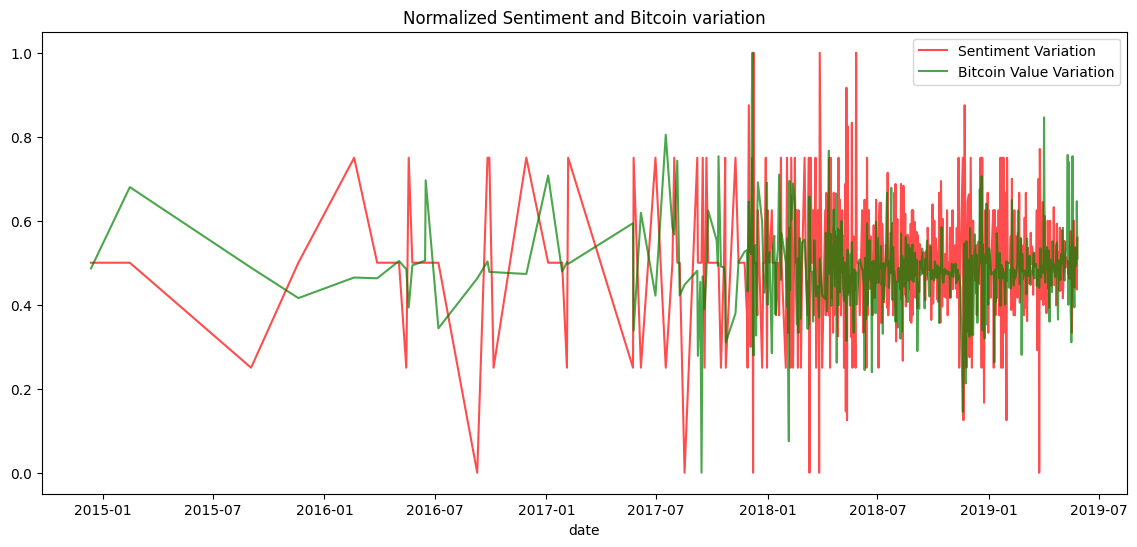

In [ ]:
## Create a chart showing both sentiment fluctuations and the value of Bitcoin by date
## Line chart
pddf.plot.line(
    x="date",
    y=["var_sent_norm", "var_price_norm"],
    label=["Sentiment Variation","Bitcoin Value Variation"],
    figsize=(14, 6),
    title="Normalized Sentiment and Bitcoin variation",
    color=["red", "green"],
    alpha=0.7
)
plt.legend()
plt.show()



###### **Note on the possible influence of changes in the value of bitcoin on changes in opinion regarding bitcoin itself**

Correlation output, scatterplot and the line chart show that there isn't any relationship between the variation of bitcoin price and the variation of sentiment tweet.

## Conclusion

- Il dataset iniziale, dopo la pulizia del testo e l'applicazione della sentiment analysis, mostra un numero di tweet con sentiment positivo (32005) e neutro (33763) maggiore di quello dei tweet con sentiment negativo (9010)

- Come mostrato dal grafico a linee, le variazioni del sentiment mostrano un apice di tweet di tutti i tipi di sentiment nella data 10-05-2019.

- Nonostante la diversa numerosità di tweet positivi e negativi, le distribuzioni di like e risposte risultano fortemente asimmetriche a destra e dominate da valori pari a zero. Di conseguenza, la mediana è pari a zero in entrambe le classi di sentiment. Inoltre, i grafici di densità (KDE) e i boxplot evidenziano una marcata sovrapposizione tra le due distribuzioni. Considerando le evidenze descrittive e grafiche, non è stato applicato alcun test statistico inferenziale (e.g. Mann–Whitney or Kolmogorov–Smirnov), in quanto l’analisi svolta risulta sufficiente a rispondere al quesito iniziale relativo alle differenze nel numero di like e di risposte tra tweet positivi e negativi. Inoltre, il seguente dataset presenta sia utenti che hanno scritto tweet positivi e negativi (violazione assunzione d'indipendenza) sia una numerosità asimmetrica che potrebbe influire sui risultati dei test.

- Infine, sebbene il grafico a linee che mostra La variazione del sentiment dei tweet riguardanti i Bitcoin e la variazione del prezzo dei Bitcoin giornarliere sembra avere delle "co-variazioni locali", in questo dataset non sono associate come mostrato dalla matrice di correlazione (*r= -0.042*) e dal grafico di regressione che individuano un'associazione quasi nulla e leggermente negativa.